# NetCDF Zarr Multi-Variable Sequential Recipe

This recipe is a little bit more complicated than the {doc}`netcdf_zarr_sequential`.
You shold probably review that one first; here we will skip the basics.

For this example, we will use data from NOAA's [World Ocean Atlas](https://www.ncei.noaa.gov/products/world-ocean-atlas).
As we can see from the [data access page](https://www.ncei.noaa.gov/access/world-ocean-atlas-2018/bin/woa18.pl), the dataset is spread over many different files.
What's important here is that:
- There is a time sequence (month) to the files.
- Different variables live in different files.

Because our dataset is spread over muliple files, we will have to use a {class}`pangeo_forge.recipe.NetCDFtoZarrMultiVarSequentialRecipe` class (rather than the simpler {class}`pangeo_forge.recipe.NetCDFtoZarrSequentialRecipe`).

## Step 1: Get to know your source data

This step can't be skipped! It's impossible to write a recipe if you don't understand intimately how the source data are organized.
World Ocean Atlass has eight different variables: Temperature, Salinity, Dissolved Oxygen, Percent Oxygen Saturation, Apparent Oxygen Utilization, Silicate, Phosphate, Nitrate.
Each variable has a page that looks like this:

![screenshot from NCEI website](ncei-woa-screenshot.png)

For the purpose of this tutorial, we will use the 5-degree resolution monthly data.
We can follow the links to finally find an HTTP download link for a single month of data.

In [1]:
download_url = 'https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/temperature/decav/5deg/woa18_decav_t01_5d.nc'

Let's download it and try to open it with xarray.

In [2]:
! wget https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/temperature/decav/5deg/woa18_decav_t01_5d.nc

connected.
HTTP request sent, awaiting response... 200 
Length: 2389903 (2.3M) [application/x-netcdf]
Saving to: ‘woa18_decav_t01_5d.nc.1’

woa18_decav_t01_5d. 100%[===================>]   2.28M  5.23MB/s    in 0.4s    

2021-02-11 14:45:40 (5.23 MB/s) - ‘woa18_decav_t01_5d.nc.1’ saved [2389903/2389903]



In [2]:
%xmode plain
import xarray as xr
ds = xr.open_dataset("woa18_decav_t01_5d.nc")

Exception reporting mode: Plain


ValueError: unable to decode time units 'months since 1955-01-01 00:00:00' with 'the default calendar'. Try opening your dataset with decode_times=False or installing cftime if it is not installed.

❗️ Oh no, we got an error!

This is a very common problem. The calendar is encoded using "months since" units, which are ambiguous in the [CF Conventions](https://cfconventions.org/Data/cf-conventions/cf-conventions-1.8/cf-conventions.html#calendar). (The precise length of a month is variable by month an year.)

We will follow the advice and do

In [4]:
ds = xr.open_dataset("woa18_decav_t01_5d.nc", decode_times=False)
ds

<xarray.Dataset>
Dimensions:             (depth: 57, lat: 36, lon: 72, nbounds: 2, time: 1)
Coordinates:
  * lat                 (lat) float32 -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
  * lon                 (lon) float32 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
  * depth               (depth) float32 0.0 5.0 10.0 ... 1.45e+03 1.5e+03
  * time                (time) float32 372.5
Dimensions without coordinates: nbounds
Data variables:
    crs                 int32 ...
    lat_bnds            (lat, nbounds) float32 ...
    lon_bnds            (lon, nbounds) float32 ...
    depth_bnds          (depth, nbounds) float32 ...
    climatology_bounds  (time, nbounds) float32 ...
    t_mn                (time, depth, lat, lon) float32 ...
    t_dd                (time, depth, lat, lon) float64 ...
    t_sd                (time, depth, lat, lon) float32 ...
    t_se                (time, depth, lat, lon) float32 ...
Attributes:
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : sea_water_tempe...
    summary:                         PRERELEASE Climatological mean temperatu...
    references:                      Locarnini, R. A., A. V. Mishonov, O. K. ...
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    id:                              woa18_decav_t01_5d.nc
    naming_authority:                gov.noaa.ncei
    sea_name:                        World-Wide Distribution
    time_coverage_start:             1955-01-01
    time_coverage_end:               2017-01-31
    time_coverage_duration:          P63Y
    time_coverage_resolution:        P01M
    geospatial_lat_min:              -90.0
    geospatial_lat_max:              90.0
    geospatial_lon_min:              -180.0
    geospatial_lon_max:              180.0
    geospatial_vertical_min:         0.0
    geospatial_vertical_max:         1500.0
    geospatial_lat_units:            degrees_north
    geospatial_lat_resolution:       5.00 degrees
    geospatial_lon_units:            degrees_east
    geospatial_lon_resolution:       5.00 degrees
    geospatial_vertical_units:       m
    geospatial_vertical_resolution:  SPECIAL
    geospatial_vertical_positive:    down
    creator_name:                    Ocean Climate Laboratory
    creator_email:                   NCEI.info@noaa.gov
    creator_url:                     http://www.ncei.noaa.gov
    creator_type:                    group
    creator_institution:             National Centers for Environmental Infor...
    project:                         World Ocean Atlas Project
    processing_level:                processed
    keywords:                        Oceans< Ocean Temperature > Water Temper...
    keywords_vocabulary:             ISO 19115
    standard_name_vocabulary:        CF Standard Name Table v49
    contributor_name:                Ocean Climate Laboratory
    contributor_role:                Calculation of climatologies
    cdm_data_type:                   Grid
    publisher_name:                  National Centers for Environmental Infor...
    publisher_institution:           National Centers for Environmental Infor...
    publisher_type:                  institution
    publisher_url:                   http://www.ncei.noaa.gov/
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   http://www.nodc.noaa.gov/OC5/WOA18/pr_wo...
    date_created:                    2018-02-19 
    date_modified:                   2018-02-19

In [5]:
ds.time

<xarray.DataArray 'time' (time: 1)>
array([372.5], dtype=float32)
Coordinates:
  * time     (time) float32 372.5
Attributes:
    standard_name:  time
    long_name:      time
    units:          months since 1955-01-01 00:00:00
    axis:           T
    climatology:    climatology_bounds

We have opened the data, but the time coordinate is just a number, not an actual datetime object.
We can work around this issue by explicitly specifying the `360_day` calendar (in which every month is assumed to have 30 days).

In [6]:
ds.time.attrs['calendar'] = '360_day'
ds = xr.decode_cf(ds)
ds

<xarray.Dataset>
Dimensions:             (depth: 57, lat: 36, lon: 72, nbounds: 2, time: 1)
Coordinates:
  * lat                 (lat) float32 -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
  * lon                 (lon) float32 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
  * depth               (depth) float32 0.0 5.0 10.0 ... 1.45e+03 1.5e+03
  * time                (time) object 1986-01-16 00:00:00
Dimensions without coordinates: nbounds
Data variables:
    crs                 int32 ...
    lat_bnds            (lat, nbounds) float32 ...
    lon_bnds            (lon, nbounds) float32 ...
    depth_bnds          (depth, nbounds) float32 ...
    climatology_bounds  (time, nbounds) float32 ...
    t_mn                (time, depth, lat, lon) float32 ...
    t_dd                (time, depth, lat, lon) float64 ...
    t_sd                (time, depth, lat, lon) float32 ...
    t_se                (time, depth, lat, lon) float32 ...
Attributes:
    Conventions:                     CF-1.6, ACDD-1.3
    title:                           World Ocean Atlas 2018 : sea_water_tempe...
    summary:                         PRERELEASE Climatological mean temperatu...
    references:                      Locarnini, R. A., A. V. Mishonov, O. K. ...
    institution:                     National Centers for Environmental Infor...
    comment:                         global climatology as part of the World ...
    id:                              woa18_decav_t01_5d.nc
    naming_authority:                gov.noaa.ncei
    sea_name:                        World-Wide Distribution
    time_coverage_start:             1955-01-01
    time_coverage_end:               2017-01-31
    time_coverage_duration:          P63Y
    time_coverage_resolution:        P01M
    geospatial_lat_min:              -90.0
    geospatial_lat_max:              90.0
    geospatial_lon_min:              -180.0
    geospatial_lon_max:              180.0
    geospatial_vertical_min:         0.0
    geospatial_vertical_max:         1500.0
    geospatial_lat_units:            degrees_north
    geospatial_lat_resolution:       5.00 degrees
    geospatial_lon_units:            degrees_east
    geospatial_lon_resolution:       5.00 degrees
    geospatial_vertical_units:       m
    geospatial_vertical_resolution:  SPECIAL
    geospatial_vertical_positive:    down
    creator_name:                    Ocean Climate Laboratory
    creator_email:                   NCEI.info@noaa.gov
    creator_url:                     http://www.ncei.noaa.gov
    creator_type:                    group
    creator_institution:             National Centers for Environmental Infor...
    project:                         World Ocean Atlas Project
    processing_level:                processed
    keywords:                        Oceans< Ocean Temperature > Water Temper...
    keywords_vocabulary:             ISO 19115
    standard_name_vocabulary:        CF Standard Name Table v49
    contributor_name:                Ocean Climate Laboratory
    contributor_role:                Calculation of climatologies
    cdm_data_type:                   Grid
    publisher_name:                  National Centers for Environmental Infor...
    publisher_institution:           National Centers for Environmental Infor...
    publisher_type:                  institution
    publisher_url:                   http://www.ncei.noaa.gov/
    publisher_email:                 NCEI.info@noaa.gov
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    license:                         These data are openly available to the p...
    metadata_link:                   http://www.nodc.noaa.gov/OC5/WOA18/pr_wo...
    date_created:                    2018-02-19 
    date_modified:                   2018-02-19

In [7]:
ds.time

<xarray.DataArray 'time' (time: 1)>
array([cftime.Datetime360Day(1986, 1, 16, 0, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1986-01-16 00:00:00
Attributes:
    standard_name:  time
    long_name:      time
    axis:           T
    climatology:    climatology_bounds

We will need this trick for later.

## Step 2: Define the Input URL Pattern

We can browse through the files on the website and see how they are organized.

```
https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/temperature/decav/5deg/woa18_decav_t01_5d.nc
https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/temperature/decav/5deg/woa18_decav_t02_5d.nc
...
https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/salinity/decav/5deg/woa18_decav_s01_5d.nc
https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/salinity/decav/5deg/woa18_decav_s02_5d.nc
...
```

From this we can deduce the general pattern.
We encode this patern as a python [format string](https://docs.python.org/3/library/string.html#format-string-syntax).

In [8]:
fmt_string="https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/{variable}/decav/5deg/woa18_decav_{variable[0]}{month:02d}_5d.nc"

We can now use the pangeo-forge `pattern` to generate the file names.
We will use a `VariableSequencePattern`, which takes two keys: one called `variable` and another one (of any name) corresponding to the sequence.

In [9]:
from pangeo_forge.patterns import VariableSequencePattern

months = list(range(1, 13))
variables = ['temperature', 'salinity']
pattern = VariableSequencePattern(
    fmt_string="https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/{variable}/decav/5deg/woa18_decav_{variable[0]}{month:02d}_5d.nc",
    keys={'variable': variables, 'month': months}
)
pattern

VariableSequencePattern(fmt_string='https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/{variable}/decav/5deg/woa18_decav_{variable[0]}{month:02d}_5d.nc', keys={'variable': ['temperature', 'salinity'], 'month': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]})

This pattern is used internally by pangeo-forge to iterate through the inputs.

In [10]:
for key, value in pattern:
    break
print(key, value)

('temperature', 1) https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/temperature/decav/5deg/woa18_decav_t01_5d.nc


## Step 3: Write the Recipe

Now that we have a `VariableSequencePattern`, we are ready to write our `NetCDFtoZarrMultiVarSequentialRecipe`.

### Define an Input Preprocessor Function

Above we noted that the time was encoded wrong in the original data.
We might have also noticed that many variables that seems like coordinates (e.g. `lat_bnds`) were in the Data Variables part of the dataset.
We will write a function that fixes both these issues.

In [11]:
def fix_encoding_and_attrs(ds, fname):
    ds.time.attrs['calendar'] = '360_day'
    ds = xr.decode_cf(ds)
    ds = ds.set_coords(['crs', 'lat_bnds', 'lon_bnds', 'depth_bnds', 'climatology_bounds'])
    return ds

### Define the Recipe Object

In [12]:
from pangeo_forge.recipe import NetCDFtoZarrMultiVarSequentialRecipe

recipe = NetCDFtoZarrMultiVarSequentialRecipe(
    input_pattern=pattern,
    sequence_dim="time",
    xarray_open_kwargs={'decode_times': False},
    process_input=fix_encoding_and_attrs
)
recipe

NetCDFtoZarrMultiVarSequentialRecipe(sequence_dim='time', inputs_per_chunk=1, nitems_per_input=1, target=<pangeo_forge.storage.UninitializedTarget object at 0x7fe160265160>, input_cache=<pangeo_forge.storage.UninitializedTarget object at 0x7fe160265820>, require_cache=True, consolidate_zarr=True, xarray_open_kwargs={'decode_times': False}, xarray_concat_kwargs={}, delete_input_encoding=True, fsspec_open_kwargs={}, process_input=<function fix_encoding_and_attrs at 0x7fe16026b9d0>, process_chunk=None, target_chunks=None, input_pattern=VariableSequencePattern(fmt_string='https://www.ncei.noaa.gov/thredds-ocean/fileServer/ncei/woa/{variable}/decav/5deg/woa18_decav_{variable[0]}{month:02d}_5d.nc', keys={'variable': ['temperature', 'salinity'], 'month': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]}))

### Assign Storage

The recipe needs a place to cache the inputs and store the target data.

In [13]:
import tempfile
from fsspec.implementations.local import LocalFileSystem
from pangeo_forge.storage import FSSpecTarget, CacheFSSpecTarget

fs_local = LocalFileSystem()

cache_dir = tempfile.TemporaryDirectory()
cache_target = CacheFSSpecTarget(fs_local, cache_dir.name)

target_dir = tempfile.TemporaryDirectory()
target = FSSpecTarget(fs_local, target_dir.name)

recipe.input_cache = cache_target
recipe.target = target

## Step 4: Run the Recipe

In {doc}`netcdf_zarr_sequential` we went through each step of recipe execution in detail.
Here we will not do that. He we will let Prefect do the work for us.

In [14]:
from pangeo_forge.executors import PrefectPipelineExecutor
executor = PrefectPipelineExecutor()
flow = executor.pipelines_to_plan(recipe.to_pipelines())
flow

<Flow: name="Rechunker">

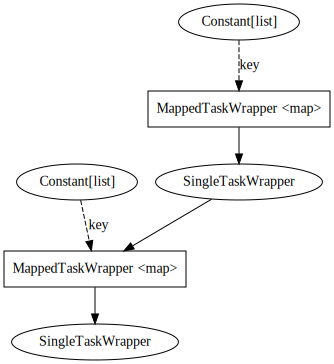

In [15]:
flow.visualize()

In [16]:
flow.run()

[2021-02-11 14:45:59-0500] INFO - prefect.FlowRunner | Beginning Flow run for 'Rechunker'
[2021-02-11 14:45:59-0500] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper': Starting task run...
[2021-02-11 14:46:00-0500] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper': Finished task run for task with final state: 'Mapped'
[2021-02-11 14:46:00-0500] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[0]': Starting task run...
[2021-02-11 14:46:01-0500] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[0]': Finished task run for task with final state: 'Success'
[2021-02-11 14:46:01-0500] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[1]': Starting task run...
[2021-02-11 14:46:02-0500] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[1]': Finished task run for task with final state: 'Success'
[2021-02-11 14:46:02-0500] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[2]': Starting task run...
[2021-02-11 14:46:03-0500] INFO - prefect.TaskRunner | Task 'MappedTaskWrapper[2

<Success: "All reference tasks succeeded.">

## Step 5: Check the Target

All the data should be there!

In [17]:
ds = xr.open_zarr(target_dir.name)
ds

<xarray.Dataset>
Dimensions:             (depth: 57, lat: 36, lon: 72, nbounds: 2, time: 12)
Coordinates:
    climatology_bounds  (time, nbounds) float32 dask.array<chunksize=(1, 2), meta=np.ndarray>
    crs                 int32 ...
  * depth               (depth) float32 0.0 5.0 10.0 ... 1.45e+03 1.5e+03
    depth_bnds          (depth, nbounds) float32 dask.array<chunksize=(57, 2), meta=np.ndarray>
  * lat                 (lat) float32 -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
    lat_bnds            (lat, nbounds) float32 dask.array<chunksize=(36, 2), meta=np.ndarray>
  * lon                 (lon) float32 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
    lon_bnds            (lon, nbounds) float32 dask.array<chunksize=(72, 2), meta=np.ndarray>
  * time                (time) object 1986-01-16 00:00:00 ... 1986-12-16 00:0...
Dimensions without coordinates: nbounds
Data variables:
    s_dd                (time, depth, lat, lon) float64 dask.array<chunksize=(1, 57, 36, 72), meta=np.ndarray>
    s_mn                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 57, 36, 72), meta=np.ndarray>
    s_sd                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 57, 36, 72), meta=np.ndarray>
    s_se                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 57, 36, 72), meta=np.ndarray>
    t_dd                (time, depth, lat, lon) float64 dask.array<chunksize=(1, 57, 36, 72), meta=np.ndarray>
    t_mn                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 57, 36, 72), meta=np.ndarray>
    t_sd                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 57, 36, 72), meta=np.ndarray>
    t_se                (time, depth, lat, lon) float32 dask.array<chunksize=(1, 57, 36, 72), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.6, ACDD-1.3
    cdm_data_type:                   Grid
    comment:                         global climatology as part of the World ...
    contributor_name:                Ocean Climate Laboratory
    contributor_role:                Calculation of climatologies
    creator_email:                   NCEI.info@noaa.gov
    creator_institution:             National Centers for Environmental Infor...
    creator_name:                    Ocean Climate Laboratory
    creator_type:                    group
    creator_url:                     http://www.ncei.noaa.gov
    date_created:                    2018-02-19 
    date_modified:                   2018-02-19 
    geospatial_lat_max:              90.0
    geospatial_lat_min:              -90.0
    geospatial_lat_resolution:       5.00 degrees
    geospatial_lat_units:            degrees_north
    geospatial_lon_max:              180.0
    geospatial_lon_min:              -180.0
    geospatial_lon_resolution:       5.00 degrees
    geospatial_lon_units:            degrees_east
    geospatial_vertical_max:         1500.0
    geospatial_vertical_min:         0.0
    geospatial_vertical_positive:    down
    geospatial_vertical_resolution:  SPECIAL
    geospatial_vertical_units:       m
    id:                              woa18_decav_t01_5d.nc
    institution:                     National Centers for Environmental Infor...
    keywords:                        Oceans< Ocean Temperature > Water Temper...
    keywords_vocabulary:             ISO 19115
    license:                         These data are openly available to the p...
    metadata_link:                   http://www.nodc.noaa.gov/OC5/WOA18/pr_wo...
    naming_authority:                gov.noaa.ncei
    nodc_template_version:           NODC_NetCDF_Grid_Template_v2.0
    processing_level:                processed
    project:                         World Ocean Atlas Project
    publisher_email:                 NCEI.info@noaa.gov
    publisher_institution:           National Centers for Environmental Infor...
    publisher_name:                  National Centers for Environmental Infor...
    publisher_type:                  inst

Just to check, we will make some pretty plots.

/opt/miniconda3/envs/pangeo2020/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


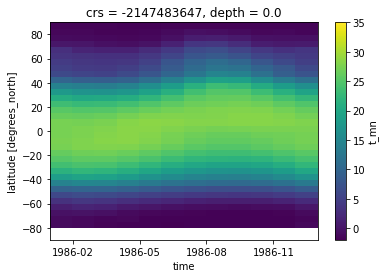

In [21]:
ds.t_mn.isel(depth=0).mean(dim='lon').plot(x='time', vmin=-2, vmax=35)

/opt/miniconda3/envs/pangeo2020/lib/python3.8/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


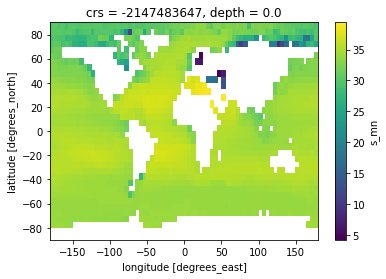

In [23]:
ds.s_mn.isel(depth=0).mean(dim='time').plot()

🎉 Yay! Our recipe worked!